In [3]:
import os
from PIL import Image, ImageEnhance, ImageFilter
import math
import cv2
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from pathlib import Path
from scipy.ndimage import gaussian_filter
from tqdm.notebook import tqdm, trange

Image.MAX_IMAGE_PIXELS = 1000000000 ## working with large image files, need to increase max pixels to avoid DDOS error
tiff_paths = []
raw_tiff = [] ## imread image files
raw_arr = [] ## images as numpy arrays
names = []
colors = list(mcolors.BASE_COLORS) + list(mcolors.TABLEAU_COLORS)
del colors[7] ## get rid of white

In [ ]:
## CREATING DIRECTORIES - **DO NOT RUN AGAIN, WILL RESET ALL IMAGES**
def create_dir():
    os.mkdir('images')
    directories = ['CZI','TIFF','MULTIPLIED','BACKGROUND_THRESHOLDED','SPLIT CHANNELS','CROPPED','HEATMAP']
    for i in directories:
        os.mkdir('images/' + i)
        
create_dir()
        
def create_dir_2():
    for i in range(len(names)):
        os.mkdir('images/CROPPED' + names[i])
        os.mkdir('images/CROPPED' + names[i] + '/c1')
        os.mkdir('images/CROPPED' + names[i] + '/c2')

create_dir_2()

In [ ]:
## Load Images in - **ONLY NEED TO RUN ONCE**

## CONVERT CZI FILES IN PROGRESS

def read_czi(read_path,write_path):
    javabridge.start_vm(class_path=bioformats.JARS)
    
    image, scale = bioformats.load_image(read_path, rescale=False, wants_max_intensity=False)
    bioformats.write_image(write_path, image)
    
    javabridge.kill_vm()

def convert_czi(directory):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and '.czi' in f:
            read_czi('images/CZI','images/TIFF')

def read_tiff(path):
    """
    path - Path to the multipage-tiff file
    """
    img = Image.open(path)
    arrays = []
    images = []
    
    images.append(img)
    arrays.append(np.array(img))
    for i in range(img.n_frames):
        img.seek(i)
        arrays.append(np.array(img))
        images.append(img)
    raw_tiff.append(images)
    return np.array(arrays)

def convert_tiff(directory,lst):
    for filename in os.listdir(directory):
        f = os.path.join(directory, filename)
        if os.path.isfile(f) and f != (directory+'/'+".DS_Store"):
            tiff_paths.append(f)
    print(len(tiff_paths))
    for path in tiff_paths:
        lst.append(read_tiff(path))
        
convert_tiff('images/TIFF',raw_arr)
print("Converted Tiffs")

In [ ]:

## INTENSITY BASED ANALYSIS

img_thresholded = []
img_multiplied = []
signal_binary = []
img_integrals = []
img_ratios = []

def threshold_img(img, threshold, name):
    thresholded = np.where(img > threshold, 1, 0)
    thresholded = thresholded.astype(np.uint16)
    
    save_img('images/BACKGROUND_THRESHOLDED',thresholded,'thres',name)               # SAVE IMAGE
    return thresholded

def otsu_threshold_img(img, name):
    otsu_thres = cv2.threshold(img, 0, 1, c]v2.THRESH_BINARY+cv2.THRESH_OTSU)[1]
    save_img('images/OTSU_THRESHOLDED',otsu_thres,'otsu_thres',name)               # SAVE IMAGE
    return otsu_thres

def multiply_img(img, background, name):
    multiplied = np.multiply(np.array(img),np.array(background))
    multiplied = multiplied.astype(np.uint16)

    save_img('images/MULTIPLIED',multiplied,'mult',name)                  # SAVE IMAGE
    return multiplied

def binary_img(img, name):
    binary = np.where(img > 0, 1, 0)
    save_img('images/BINARY',binary,'binary',name)
    return binary

def summation(background, signals):
    return (np.sum(background), np.sum(signals))

def save_img(path,arr,prefix,name):
    img = Image.fromarray(arr.astype(np.uint16))
    img.save(path + '/' + prefix + ' ' + name + '.tif')

names = [path[12:path.find('.tif')] for path in tiff_paths]


## PROCESSING ALL OF THE IMAGES

for i in trange(len(raw_arr)):
    img_thresholded.append(otsu_threshold_img(raw_arr[i][1], names[i]))
    img_multiplied.append(multiply_img(raw_arr[i][2], img_thresholded[i], names[i]))
    img_integrals.append(summation(img_thresholded[i], img_multiplied[i]))
    img_ratios.append(img_integrals[i][1]/img_integrals[i][0])
    
print('processed')
    
## DATA PRESENTATION
for i in range(len(names)):
    print(names[i], '-', img_ratios[i])
    print(img_integrals[i])
plt.bar(names, img_ratios,color=colors[:len(names)])
plt.xticks([])
plt.show()

In [ ]:
## HEAT MAP OF IMAGES - GAUSSIAN BLUR, save in images/HEATMAP
def gauss_blur():
    for i in range(len(names)):
        img = raw_tiff[i].convert('I;16').filter(ImageFilter.GaussianBlur(radius = 60))
        img.save('images/HEATMAP/heatmap', names[i])
    print('done')
    
gauss_blur()

In [ ]:
## CELL PROFILER CELL-BASED ANALYSIS

import cellprofiler_core.pipeline
import cellprofiler_core.preferences
import cellprofiler_core.utilities.java
import cellprofiler.modules.identifyprimaryobjects

cp_data = np.empty(shape=(len(names),2))

# BATCH IMAGES
def crop_image(directory,img,w,h):
    cropped_lst = []
    crop_w = math.floor(img.size[0]/w)
    crop_h = math.floor(img.size[1]/h)
    for i in range(0,h):
        for j in range(0,w):
            (img.crop((j*crop_w, i*crop_h, j*crop_w+crop_w, i*crop_h+crop_h))).save(directory+'_cropped'+str(i*w+j)+'.tif')
            
## CROP SIGNALS
def crop_signals():
    for filename in os.listdir('images/MULTIPLIED'):
        f = os.path.join('images/MULTIPLIED', filename)
        if os.path.isfile(f) and 'HBC' in f:
            crop_image(('images/CROPPED/' + filename[5:filename.find('.tif')] + '/c2/'),(Image.open(f)),30,30)
            print(filename)
    
## THRESHOLDED DAPI
def threshold_dapi(thres,back,name):
    multiplied = np.multiply(np.array(thres),np.array(back))
    multiplied = multiplied.astype(np.uint16)

    save_img('images/BACKGROUND_MULT',multiplied,'backmult',name)                  # SAVE IMAGE

def crop_dapi():
    for filename in os.listdir('images/BACKGROUND_MULT'):
        f = os.path.join('images/BACKGROUND_MULT', filename)
        if os.path.isfile(f) and 'HBC' in f:
            crop_image(('images/CROPPED/' + filename[9:filename.find('.tif')] + '/c1/'),(Image.open(f)),30,30)
            print(filename)

def cp_analyse(path):
    cellprofiler_core.preferences.set_headless()

    cellprofiler_core.utilities.java.start_java()

    pipeline = cellprofiler_core.pipeline.Pipeline()
    pipeline.load('cellprofiler_analysis.cppipe')

    file_list = list(pathlib.Path('.').absolute().glob(path+'/*.tif'))
    files = [file.as_uri() for file in file_list]
    pipeline.read_file_list(files)

    output_measurements = pipeline.run()
    
    return_value = len(output_measurements.get_measurement_columns())

    cellprofiler_core.utilities.java.stop_java()
    return return_value

def analyse_all():
    for i in range(len(names)):
        cp_data[i][0].append(cp_analyse('images/CROPPED/' + names[i] + '/c1'))
        c2_data[i][1].append(cp_analyse('images/CROPPED/' + names[i] + '/c2'))

## DATA PRESENTATION
def do_the_data():
    for i in range(len(names)):
        print(names[i], '-', cell_ratios[i], '-', cp_data[i][0], '-', cp_data[i][1])
    plt.bar(names, cell_ratios,color=colors[:len(names)])
    plt.xticks([])
    plt.show()
    
    
crop_signals()
for i in range(len(names)):
    threshold_dapi(img_thresholded[i],raw_arr[i][0],names[i])
crop_dapi()
crop_22()
print('done')
    
process_results()
cell_ratios = [datum[0]/datum[1] for datum in cp_data]
do_the_data()

[ 0.         -0.04994209 -0.099144   -0.14600822 -0.188416   -0.22412109
 -0.251076   -0.26769072 -0.273024   -0.26690709 -0.25       -0.22378022
 -0.190464   -0.15286009 -0.114156   -0.07763672 -0.046336   -0.02262009
 -0.007704   -0.00110022  0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.00110022
  0.007704    0.02262009  0.046336    0.07763672  0.114156    0.15286009
  0.190464    0.22378022  0.25        0.26690709  0.273024    0.26769072
  0.251076    0.22412109  0.188416    0.14600822  0.099144    0.04994209
  0.         -0.04994209 -0.099144   -0.14600822 -0.188416   -0.22412109
 -0.251076   -0.26769072 -0.273024   -0.26690709 -0.25       -0.22378022
 -0.190464   -0.15286009 -0.114156   -0.07763672 -0.046336   -0.02262009
 -0.007704   -0.00110022  0.          0.          0.          0.
  0.      

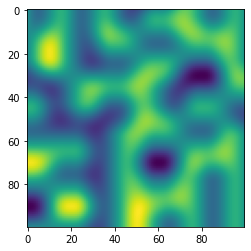

In [12]:
## test image

def perlin(x, y, seed=0):
    # permutation table
    np.random.seed(seed)
    p = np.arange(256, dtype=int)
    np.random.shuffle(p)
    p = np.stack([p, p]).flatten()
    # coordinates of the top-left
    xi, yi = x.astype(int), y.astype(int)
    # internal coordinates
    xf, yf = x - xi, y - yi
    # fade factors
    u, v = fade(xf), fade(yf)
    # noise components
    n00 = gradient(p[p[xi] + yi], xf, yf)
    n01 = gradient(p[p[xi] + yi + 1], xf, yf - 1)
    n11 = gradient(p[p[xi + 1] + yi + 1], xf - 1, yf - 1)
    n10 = gradient(p[p[xi + 1] + yi], xf - 1, yf)
    # combine noises
    x1 = lerp(n00, n10, u)
    x2 = lerp(n01, n11, u)  # FIX1: I was using n10 instead of n01
    return lerp(x1, x2, v)  # FIX2: I also had to reverse x1 and x2 here

def lerp(a, b, x):
    "linear interpolation"
    return a + x * (b - a)

def fade(t):
    "6t^5 - 15t^4 + 10t^3"
    return 6 * t**5 - 15 * t**4 + 10 * t**3

def gradient(h, x, y):
    "grad converts h to the right gradient vector and return the dot product with (x,y)"
    vectors = np.array([[0, 1], [0, -1], [1, 0], [-1, 0]])
    g = vectors[h % 4]
    return g[:, :, 0] * x + g[:, :, 1] * y

lin = np.linspace(0, 5, 100, endpoint=False)
x, y = np.meshgrid(lin, lin)  # FIX3: I thought I had to invert x and y here but it was a mistake

plt.imshow(perlin(x, y, seed=230498), origin='upper')
print(perlin(x,y, seed=2)[0])

In [4]:
## Heterogeneity score
from skimage.draw import line
from itertools import combinations

test_img = np.random.rand(50,50)
test_img = test_img * 256
test_img = np.floor(test_img)

def heterogeneity_score(img):
    #average absolute intensity
    aai_lst = [[],[]]
    aai_dict = {}
    all_points_1 = combinations
    xy_coords1 = np.flip(np.column_stack(np.where(img)), axis=1)
    xy_coords2 = np.flip(np.column_stack(np.where(img)), axis=1)
    
    for i in trange(len(xy_coords1)):
        for j in range(len(xy_coords2)):
            x_1 = xy_coords1[i][0]
            y_1 = xy_coords1[i][1]
            x_2 = xy_coords2[j][0]
            y_2 = xy_coords2[j][1]
            if x_1 == x_2 and y_1 == y_2:
                pass
            calculated_i = avg_intensity(img,x_1,y_1,x_2,y_2)
            if calculated_i[0] in aai_lst[0]:
                aai_lst[1][aai_lst[0].index(calculated_i[0])].append(calculated_i[1])
            else:
                aai_lst[0].append(calculated_i[0])
                aai_lst[1].append([calculated_i[1]])
    
    aai_arr = np.array(aai_lst)
    
def avg_intensity(img,x_m,y_m,x_n,y_n):
    intensity_m = img[y_m][x_m]
    intensity_n = img[y_n][x_n]
    r_mn = math.dist((x_m,y_m), (x_n,y_n))
    bresenham_points = line(x_m,y_m,x_n,y_n)
    summation = 0
    
    for i in range(len(bresenham_points[0])):
        x_l = bresenham_points[0][i]
        y_l = bresenham_points[1][i]
        intensity_l = img[y_l][x_l]
        r_ml = math.dist((x_m,y_m), (x_l,y_l))
        
        # print(x_l,y_l)
        intensity_r_ml = intensity_m + (((intensity_n-intensity_m)/r_mn) * r_ml)
        summation += abs(intensity_r_ml - intensity_l)
    
    avg_abs_intensity = summation / len(bresenham_points[0])
    return (len(bresenham_points[0]), avg_abs_intensity)

print(avg_intensity(test_img,10,12,25,40))
test = heterogeneity_score(test_img)

(29, 78.36706287955795)


  0%|          | 0/2497 [00:00<?, ?it/s]

/var/folders/mf/zszwkwsd6p121df2kwsxf7hr0000gn/T/ipykernel_2495/3169233246.py:48: RuntimeWarning: invalid value encountered in double_scalars
  intensity_r_ml = intensity_m + (((intensity_n-intensity_m)/r_mn) * r_ml)
/var/folders/mf/zszwkwsd6p121df2kwsxf7hr0000gn/T/ipykernel_2495/3169233246.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  aai_arr = np.array(aai_lst)
